# Domain Generalization (IRM) on PACS

In [2]:
import os
import random
from pathlib import Path
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, ConcatDataset, Subset, random_split
from torchvision import transforms, datasets

from irm import IRMTrainer, RemapLabels  # assume RemapLabels from your local code

# ----- Config -----
DATA_ROOT = Path(r"C:\Users\Fatim_Sproj\Desktop\Fatim\Spring 2025\Datasets\pacs_data\pacs_data")
SOURCE_DOMAINS = ["art_painting", "cartoon", "photo"]
TARGET_DOMAIN = "sketch"

IMAGE_SIZE = 224
PER_DOMAIN_BATCH = 64                # DomainBed convention: batch size per domain
NUM_EPOCHS = 50
STEPS_PER_VAL = 75                     # evaluate every 75 steps (you previously used 75)
BASE_LR = 1e-4
WEIGHT_DECAY = 0.0
IRM_LAMBDA = 1e3
PENALTY_ANNEAL_ITERS = 500
SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

random.seed(SEED)
torch.manual_seed(SEED)

In [3]:
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

val_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

def load_imagefolder(domain_name, transform):
    p = DATA_ROOT / domain_name
    if not p.exists():
        raise FileNotFoundError(f"Domain path not found: {p.resolve()}")
    return datasets.ImageFolder(str(p), transform=transform)

# ----- Raw datasets per domain (before remap & split) -----
raw_sources = {d: load_imagefolder(d, train_transform) for d in SOURCE_DOMAINS}
raw_target = load_imagefolder(TARGET_DOMAIN, val_transform)

canonical_map = raw_sources[SOURCE_DOMAINS[0]].class_to_idx
NUM_CLASSES = len(canonical_map)

# Remap labels and split each source domain into train/val (DomainBed: use within-source val)
source_train_loaders = {}
source_val_loaders = {}
for d, raw_ds in raw_sources.items():
    remapped = RemapLabels(raw_ds, canonical_map)
    n = len(remapped)
    # DomainBed tends to use an 80/20 train/val split per domain (consistent with DomainBed practice)
    val_size = int(0.2 * n)
    train_size = n - val_size
    train_ds, val_ds = random_split(remapped, [train_size, val_size], generator=torch.Generator().manual_seed(SEED))
    source_train_loaders[d] = DataLoader(train_ds, batch_size=PER_DOMAIN_BATCH, shuffle=True, num_workers=0, pin_memory=True)
    source_val_loaders[d] = DataLoader(val_ds, batch_size=PER_DOMAIN_BATCH, shuffle=False, num_workers=0, pin_memory=True)

# Target loader (test only)
target_dataset = RemapLabels(raw_target, canonical_map)
target_loader = DataLoader(target_dataset, batch_size=PER_DOMAIN_BATCH, shuffle=False, num_workers=0, pin_memory=True)

# Print sizes
total_train_examples = sum(len(loader.dataset) for loader in source_train_loaders.values())
total_val_examples = sum(len(loader.dataset) for loader in source_val_loaders.values())
print(f"Total train examples (all domains): {total_train_examples}, total per-domain val examples: {total_val_examples//len(source_val_loaders)}")
print(f"Num classes: {NUM_CLASSES}")

Total train examples (all domains): 4843, total per-domain val examples: 403
Num classes: 7


In [4]:
import torchvision

class DomainBedModel(nn.Module):
    def __init__(self, featurizer, classifier, dropout_rate=0.0):
        super().__init__()
        self.featurizer = featurizer
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = classifier

    def forward(self, x):
        features = self.featurizer(x)
        features_dropped_out = self.dropout(features)
        return self.fc(features_dropped_out)

resnet_dropout = 0.0
freeze_bn_flag = True

base_model = torchvision.models.resnet18(pretrained=True)
n_outputs = base_model.fc.in_features
base_model.fc = nn.Identity()
featurizer = base_model

if freeze_bn_flag:
    for module in featurizer.modules():
        if isinstance(module, nn.BatchNorm2d):
            module.eval()

classifier = nn.Linear(n_outputs, NUM_CLASSES)

model = DomainBedModel(featurizer, classifier, dropout_rate=resnet_dropout).to(DEVICE)

c:\Users\Fatim_Sproj\anaconda3\envs\bacp\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Fatim_Sproj\anaconda3\envs\bacp\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
# ----- IRMTrainer setup -----
hparams = {
    'lr': BASE_LR,
    'weight_decay': WEIGHT_DECAY,
    'irm_lambda': IRM_LAMBDA,
    'penalty_anneal_iters': PENALTY_ANNEAL_ITERS
}

irm_algo = IRMTrainer(
    model=model,
    optimizer=None,
    irm_lambda=hparams["irm_lambda"],
    penalty_anneal_iters=hparams["penalty_anneal_iters"],
    device=DEVICE
)

optimizer = torch.optim.Adam(model.parameters(), lr=hparams['lr'], weight_decay=hparams['weight_decay'])
irm_algo.optimizer = optimizer

@torch.no_grad()
def evaluate_on_loader(model, loader, device):
    model.eval()
    total, correct, total_loss = 0, 0, 0.0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = F.cross_entropy(logits, y)
        total_loss += loss.item() * x.size(0)
        preds = logits.argmax(1)
        correct += (preds == y).sum().item()
        total += x.size(0)
    return total_loss / total, 100.0 * correct / total

def evaluate_on_source_val(model, source_val_loaders, device):
    losses, accs, ns = [], [], []
    for d, loader in source_val_loaders.items():
        loss, acc = evaluate_on_loader(model, loader, device)
        losses.append(loss * len(loader.dataset))
        accs.append(acc * len(loader.dataset) / 100.0)
        ns.append(len(loader.dataset))
    total_n = sum(ns)
    avg_loss = sum(losses) / total_n
    avg_acc = 100.0 * (sum(accs) / total_n)
    return avg_loss, avg_acc

In [6]:
import json
from pathlib import Path
from tqdm import tqdm
import torch
import copy

BASE_LR = 1e-4
NUM_EPOCHS = 20
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Sweep configs
LAMBDA_SWEEP = [10, 100, 1000]
ANNEAL_SWEEP = [100, 500, 1000]

OUTPUT_DIR = Path('./irm_ablation_focused')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

source_train_loader_list = [source_train_loaders[d] for d in SOURCE_DOMAINS]
min_steps_per_domain = min(len(dl) for dl in source_train_loader_list)
total_steps_per_run = NUM_EPOCHS * min_steps_per_domain

STEPS_PER_VAL = max(1, min_steps_per_domain)
initial_state = copy.deepcopy(model.state_dict())

ablation_summary = []

# ---------- (1) Lambda Sweep ----------
for lam in LAMBDA_SWEEP:
    ann = 1000
    cfg_name = f"lam{lam}_ann{ann}"
    run_output = OUTPUT_DIR / f"{cfg_name}.json"

    model.load_state_dict(copy.deepcopy(initial_state))
    model.to(DEVICE)
    model.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=BASE_LR)
    irm_algo = IRMTrainer(model, optimizer, irm_lambda=lam, penalty_anneal_iters=ann, device=DEVICE)

    logs = {"step": [], "loss": [], "nll": [], "penalty": [], "target_acc": []}
    best_target_acc = 0.0
    iters = [iter(dl) for dl in source_train_loader_list]
    step_metrics = {"loss": 0.0, "nll": 0.0, "penalty": 0.0}

    pbar = tqdm(range(total_steps_per_run), desc=f"IRM λ={lam}", leave=True)
    for step in pbar:
        minibatches = []
        for i, it in enumerate(iters):
            try:
                x, y = next(it)
            except StopIteration:
                iters[i] = iter(source_train_loader_list[i])
                x, y = next(iters[i])
            minibatches.append((x.to(DEVICE), y.to(DEVICE)))

        metrics = irm_algo.step(minibatches)
        for k in ("loss", "nll", "penalty"):
            step_metrics[k] += float(metrics.get(k, 0.0))

        avg_metrics = {k: step_metrics[k] / (step + 1) for k in step_metrics}
        pbar.set_postfix({"loss": avg_metrics["loss"], "pen": avg_metrics["penalty"]})

        if (step + 1) % STEPS_PER_VAL == 0 or step == total_steps_per_run - 1:
            target_loss, target_acc = evaluate_on_loader(model, target_loader, DEVICE)
            logs["step"].append(step + 1)
            logs["loss"].append(avg_metrics["loss"])
            logs["nll"].append(avg_metrics["nll"])
            logs["penalty"].append(avg_metrics["penalty"])
            logs["target_acc"].append(float(target_acc))
            if float(target_acc) > best_target_acc:
                best_target_acc = float(target_acc)
                torch.save(model.state_dict(), OUTPUT_DIR / f"best_model_{cfg_name}.pth")

    result = {"config": {"irm_lambda": lam, "penalty_anneal_iters": ann}, "best_target_acc": best_target_acc}
    with open(run_output, "w") as f:
        json.dump({"logs": logs, **result}, f, indent=2)
    ablation_summary.append(result)

# ---------- (2) Anneal Sweep ----------
for ann in ANNEAL_SWEEP:
    lam = 100
    cfg_name = f"lam{lam}_ann{ann}"
    run_output = OUTPUT_DIR / f"{cfg_name}.json"

    model.load_state_dict(copy.deepcopy(initial_state))
    model.to(DEVICE)
    model.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=BASE_LR)
    irm_algo = IRMTrainer(model, optimizer, irm_lambda=lam, penalty_anneal_iters=ann, device=DEVICE)

    logs = {"step": [], "loss": [], "nll": [], "penalty": [], "target_acc": []}
    best_target_acc = 0.0
    iters = [iter(dl) for dl in source_train_loader_list]
    step_metrics = {"loss": 0.0, "nll": 0.0, "penalty": 0.0}

    pbar = tqdm(range(total_steps_per_run), desc=f"IRM anneal={ann}", leave=True)
    for step in pbar:
        minibatches = []
        for i, it in enumerate(iters):
            try:
                x, y = next(it)
            except StopIteration:
                iters[i] = iter(source_train_loader_list[i])
                x, y = next(iters[i])
            minibatches.append((x.to(DEVICE), y.to(DEVICE)))

        metrics = irm_algo.step(minibatches)
        for k in ("loss", "nll", "penalty"):
            step_metrics[k] += float(metrics.get(k, 0.0))

        avg_metrics = {k: step_metrics[k] / (step + 1) for k in step_metrics}
        pbar.set_postfix({"loss": avg_metrics["loss"], "pen": avg_metrics["penalty"]})

        if (step + 1) % STEPS_PER_VAL == 0 or step == total_steps_per_run - 1:
            target_loss, target_acc = evaluate_on_loader(model, target_loader, DEVICE)
            logs["step"].append(step + 1)
            logs["loss"].append(avg_metrics["loss"])
            logs["nll"].append(avg_metrics["nll"])
            logs["penalty"].append(avg_metrics["penalty"])
            logs["target_acc"].append(float(target_acc))
            if float(target_acc) > best_target_acc:
                best_target_acc = float(target_acc)
                torch.save(model.state_dict(), OUTPUT_DIR / f"best_model_{cfg_name}.pth")

    result = {"config": {"irm_lambda": lam, "penalty_anneal_iters": ann}, "best_target_acc": best_target_acc}
    with open(run_output, "w") as f:
        json.dump({"logs": logs, **result}, f, indent=2)
    ablation_summary.append(result)

# ---------- Save Summary ----------
summary_path = OUTPUT_DIR / "ablation_summary.json"
with open(summary_path, "w") as f:
    json.dump(ablation_summary, f, indent=2)

IRM anneal=1000: 100%|██████████| 420/420 [25:36<00:00,  3.66s/it, loss=0.0715, pen=0.00628]


Loaded 5 ablation runs successfully.


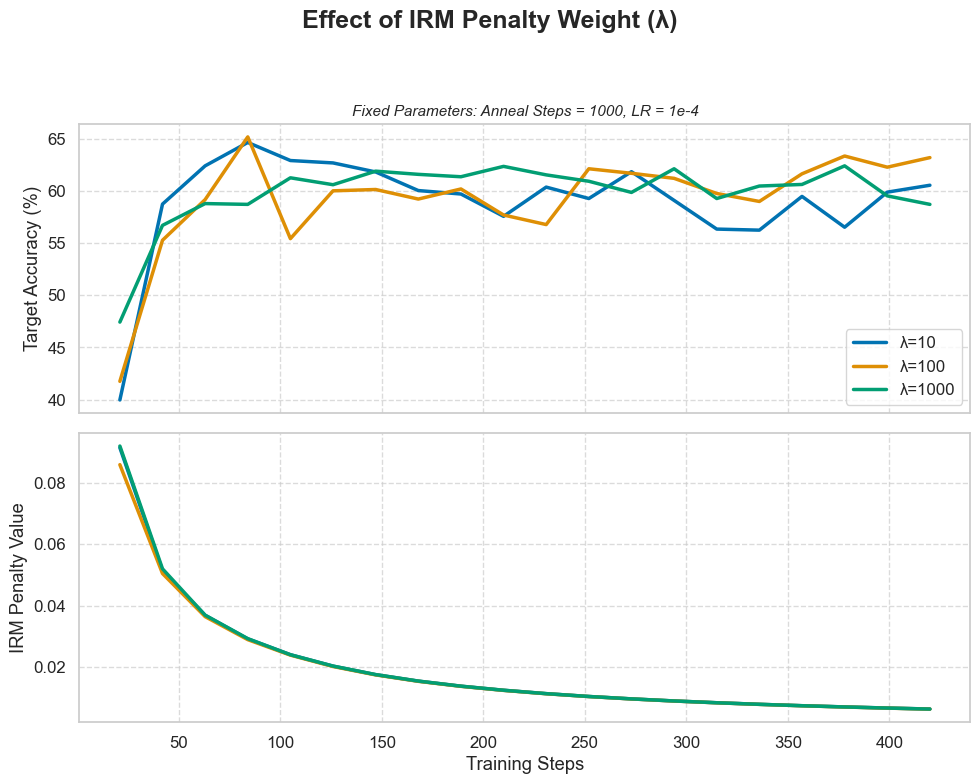

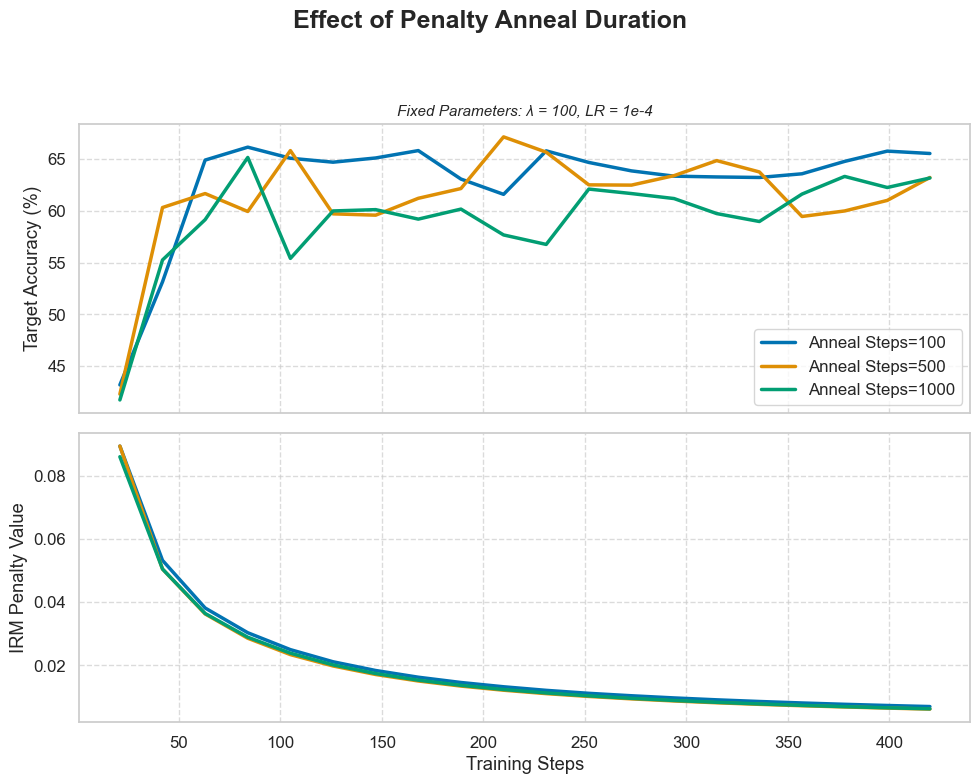

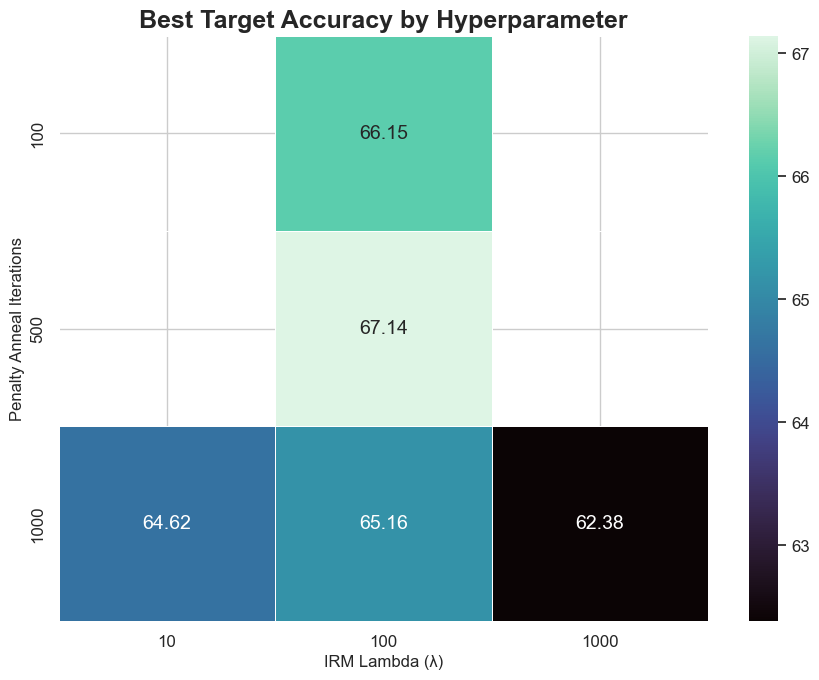

In [7]:
import json
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Use a professional and accessible plotting style
sns.set_theme(style="whitegrid", palette="colorblind", font_scale=1.1)

# --- (1) Data Loading and Preparation ---
OUTPUT_DIR = Path('./irm_ablation_focused')
records = []

# Load all JSON results, skipping the summary file
for js_path in sorted(OUTPUT_DIR.glob("*.json")):
    if js_path.name == "ablation_summary.json":
        continue
    with open(js_path, "r") as f:
        data = json.load(f)
    
    # Create a DataFrame from the time-series logs for easy plotting
    log_df = pd.DataFrame(data['logs'])
    
    records.append({
        "irm_lambda": data['config']['irm_lambda'],
        "penalty_anneal_iters": data['config']['penalty_anneal_iters'],
        "best_target_acc": data['best_target_acc'],
        "log_df": log_df
    })

df = pd.DataFrame(records)
print(f"Loaded {len(df)} ablation runs successfully.")

# --- (2) Reusable Plotting Function for Clarity ---
def plot_ablation_figure(df_subset, param_col, param_name, title, subtitle):
    """
    Generates a high-quality, two-panel figure showing the effect of one
    hyperparameter on target accuracy and the IRM penalty.
    """
    fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    
    # Sort by the parameter value to ensure a consistent legend order
    df_subset = df_subset.sort_values(by=param_col)
    
    for _, row in df_subset.iterrows():
        label = f"{param_name}={int(row[param_col])}"
        log_data = row['log_df']
        
        # Top Panel: Target Accuracy
        axes[0].plot(log_data["step"], log_data["target_acc"], label=label, linewidth=2.5)
        
        # Bottom Panel: IRM Penalty
        axes[1].plot(log_data["step"], log_data["penalty"], label=label, linewidth=2.5)

    # Formatting for the Accuracy Plot
    axes[0].set_ylabel("Target Accuracy (%)")
    axes[0].legend()
    axes[0].set_title(subtitle, fontsize=11, style='italic')

    # Formatting for the Penalty Plot
    axes[1].set_ylabel("IRM Penalty Value")
    axes[1].set_xlabel("Training Steps")

    for ax in axes:
        ax.grid(True, linestyle="--", alpha=0.7)
    
    fig.suptitle(title, fontsize=18, weight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.94])
    plt.show()

# --- (3) Generate Specific Plots for Each Ablation ---

# Plot 1: Effect of IRM Lambda
lambda_sweep_df = df[df["penalty_anneal_iters"] == 1000]
plot_ablation_figure(
    df_subset=lambda_sweep_df,
    param_col='irm_lambda',
    param_name='λ',
    title="Effect of IRM Penalty Weight (λ)",
    subtitle="Fixed Parameters: Anneal Steps = 1000, LR = 1e-4"
)

# Plot 2: Effect of Penalty Annealing
anneal_sweep_df = df[df["irm_lambda"] == 100]
plot_ablation_figure(
    df_subset=anneal_sweep_df,
    param_col='penalty_anneal_iters',
    param_name='Anneal Steps',
    title="Effect of Penalty Anneal Duration",
    subtitle="Fixed Parameters: λ = 100, LR = 1e-4"
)

# --- (4) Generate a Summary Heatmap ---
pivot_df = df.pivot_table(
    values="best_target_acc",
    index="penalty_anneal_iters",
    columns="irm_lambda"
)

plt.figure(figsize=(9, 7))
sns.heatmap(
    pivot_df,
    annot=True,
    fmt=".2f",
    cmap="mako",
    linewidths=.5,
    annot_kws={"size": 14}
)
plt.title("Best Target Accuracy by Hyperparameter", fontsize=18, weight='bold')
plt.xlabel("IRM Lambda (λ)", fontsize=12)
plt.ylabel("Penalty Anneal Iterations", fontsize=12)
plt.tight_layout()
plt.show()